<a href="https://colab.research.google.com/github/mjvakili/cassava_desease_classification/blob/master/cassava_disease_classification_inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup and importing libraries

Let us begin by importing the libraries that we need for solving this problem.

In [0]:
import os
import zipfile
import matplotlib
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sys
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from glob import glob 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#Keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras import backend as K
#sklearn helpers
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

# Data Preperation

Now we download the publicly available dataset containing the images of *Cassava leaves*. These images belong to five category: one healthy category, and 4 category corresponding to four different types of deseases. 

In [4]:
#Download the file and save it in a temporary placeholder '/tmp'
!wget --no-check-certificate \
  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip \
  -O /tmp/cassavaleafdata.zip

#Unzip the file in '/tmp'
local_zip = '/tmp/cassavaleafdata.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#Split the data into train, valid, test folders
base_dir = '/tmp/cassavaleafdata'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

--2020-01-27 17:38:07--  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354096203 (1.3G) [application/zip]
Saving to: ‘/tmp/cassavaleafdata.zip’

/tmp/cassavaleafdat 100%[===================>]   1.26G  78.7MB/s    in 16s     

2020-01-27 17:38:24 (81.3 MB/s) - ‘/tmp/cassavaleafdata.zip’ saved [1354096203/1354096203]



In [0]:
def preprocess(directory):
  '''
  Return the standardized format of all the 
  images in a given directory (ex: 'train', 'test', 'valid')
  '''
  image_files = list(paths.list_images(directory))
  #data and label placeholders
  arrays, labels = [], []
  cnt = 0
  for img in image_files:
    #find the label of the file
    label = img.split('/')[-2]
    # standardize the images: convert to RGB & resize to (224, 224)
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    #add the image and label to the place holders
    arrays.append(image)
    labels.append(label)
    cnt += 1
  #convert these to numpy arrays  
  arrays = np.array(arrays, dtype="float32")
  labels = np.array(labels)
 
  return arrays, labels

In [0]:
#a placeholder for training data and the training labels
train_data, train_labels = preprocess(train_dir)
#a placeholder for validation (dev) data and the validation (dev) labels
valid_data, valid_labels = preprocess(valid_dir)
#a placeholder for test data and the test labels
test_data, test_labels = preprocess(test_dir)

##One-hot encoding transformation of the labels:

Now that we have a placeholder for the labels in the training, dev, and the test set, we perform one-hot encoding to transform the labels (strings) to one-hot vectors. The length of each vector will be equal to the number of classes in the data.

In [0]:
Binarizer = LabelBinarizer()
train_y = Binarizer.fit_transform(train_labels)
valid_y = Binarizer.transform(valid_labels)
test_y = Binarizer.transform(test_labels)

In [0]:
#shuffling the training data
train_indx = np.arange(len(train_labels))
np.random.shuffle(train_indx)
train_data, train_y = train_data[train_indx], train_y[train_indx]

In [0]:
#rescaling the images such that the pixel values are between one and zero
train_data = train_data / 255.
valid_data = valid_data / 255.
test_data = test_data / 255.

Let's take a look at the distribution of classes. We note that the training, the dev, and the test sets are drawn from the same distribution which makes the model trained on training examples generalize better to the unseen examples in the dev and the test set. We also note that the data is very imbalanced. Therefore, we need to inspect the confusion matrix later on to see how successful the model is at distinguishing between the 5 classes.

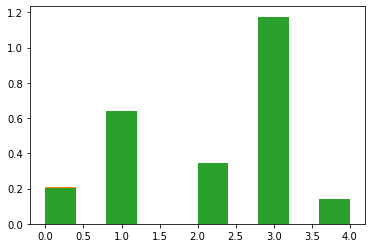

In [10]:
dist1 = plt.hist(train_y.argmax(axis = 1), density = True)
dist2 = plt.hist(valid_y.argmax(axis = 1), density = True)
dist3 = plt.hist(test_y.argmax(axis = 1), density = True)

#Image augmentation

For training our model, we have a dataset with a limited size. 
One way to alleviate this problem  is to use Image Augmentation.
In image augmentation, a set of transformations are applied to the training examples *on the fly* during the training process. For instance, the images are 
*rotated*, *shifted*, *flipped*, *distorted* (with a prespecified range of a shear parameter). Note that these transformations are performed on the fly: these transformations are done on every example in a given batch during the gradient descent, and in the next batch iteration, a new set of transformations are done on a different set of examples in a different batch. This technique ensures that the network never looks at the same example in the original training data twice and therefore it helps avoid overfitting. 

In [0]:
train_augment = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

valid_augment = ImageDataGenerator()

train_augment.fit(train_data)
valid_augment.fit(valid_data)


#Inception V3 fine tuning

We use transfer learning to the classify teh images in the data. 
In particular we use the Inception V3 model without the top dense layers. That is, we only keep the convolutional layers. We flatten the last convolutional activation layer of Inception V3 using the Global average pooling. The output is then feeded to a dense layer with 512 hidden units, followed by a dropout with dropout rate of 0.5, followed by a softmax activation layer for the purpose of multi-class classification.

We train the model in two steps: 

1.   Step one: We keep the convolutional layers of the Inception model frozen, that is we don't let the inception weights vary. So the only trainable parameters are the parameters of the weight matrices of the top dense layer. 


2.  Once, the parameters of the top dense layers are tuned, we unfreeze the parameters of the convolutional layer and then we retrain all the parameters including the Inception weights and biases. In our experiments we have noticed that retraining the Inception V3 convolutional layers achieves better results.

In [0]:
baseModel = InceptionV3(weights="imagenet", include_top=False, input_shape = (224, 224, 3))
#Freeze the Inception V3 layers:
for layer in baseModel.layers:
	layer.trainable = False

x = baseModel.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

# Configure and compile the model
model = Model(baseModel.input, x)
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [17]:
BATCH_SIZE = 64
NEPOCHS = 4
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size = BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE))

Epoch 1/4
88/88 [==============================] - 63s 719ms/step - loss: 1.8919 - acc: 0.4125 - val_loss: 1.3826 - val_acc: 0.4623
Epoch 2/4
88/88 [==============================] - 61s 690ms/step - loss: 1.2887 - acc: 0.5131 - val_loss: 1.3330 - val_acc: 0.4828
Epoch 3/4
88/88 [==============================] - 60s 684ms/step - loss: 1.2267 - acc: 0.5345 - val_loss: 1.3158 - val_acc: 0.4649
Epoch 4/4
88/88 [==============================] - 60s 685ms/step - loss: 1.2036 - acc: 0.5476 - val_loss: 1.2863 - val_acc: 0.4903


In [0]:
for layer in baseModel.layers:
    layer.trainable = True

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [21]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/30
88/88 [==============================] - 76s 860ms/step - loss: 1.0070 - acc: 0.6336 - val_loss: 0.7840 - val_acc: 0.7220
Epoch 2/30
88/88 [==============================] - 63s 716ms/step - loss: 0.7852 - acc: 0.7198 - val_loss: 0.6651 - val_acc: 0.7608
Epoch 3/30
88/88 [==============================] - 62s 705ms/step - loss: 0.6655 - acc: 0.7637 - val_loss: 0.6575 - val_acc: 0.7770
Epoch 4/30
88/88 [==============================] - 62s 700ms/step - loss: 0.5420 - acc: 0.8105 - val_loss: 0.5797 - val_acc: 0.8017
Epoch 5/30
88/88 [==============================] - 61s 697ms/step - loss: 0.4950 - acc: 0.8323 - val_loss: 0.5688 - val_acc: 0.7971
Epoch 6/30
88/88 [==============================] - 61s 698ms/step - loss: 0.4202 - acc: 0.8578 - val_loss: 0.5878 - val_acc: 0.8362
Epoch 7/30
88/88 [==============================] - 62s 702ms/step - loss: 0.3848 - acc: 0.8660 - val_loss: 0.5009 - val_acc: 0.8239
Epoch 8/30
88/88 [==============================] - 61s 694ms/step - 

Note that the learning rate is perhaps the most hyperparameter of our model. 
In this code block we perform a simple grid search to find an appropriate value of the learning rate

# Inspection of the learning curves:

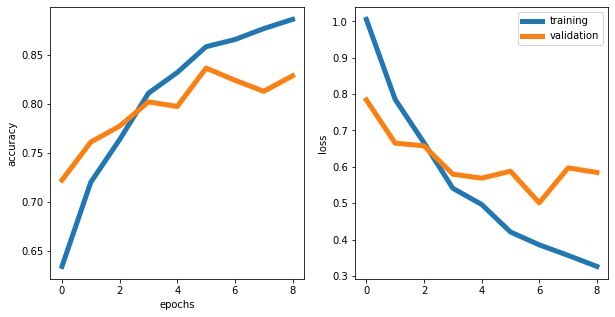

In [27]:
fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (10,5))
axs[0].plot(range(len(history.history['acc'])), history.history['acc'], linewidth = 5, label = "training")
axs[0].plot(range(len(history.history['acc'])), history.history['val_acc'], linewidth = 5, label = "validation")
axs[1].plot(range(len(history.history['loss'])), history.history['loss'], linewidth = 5, label = "training")
axs[1].plot(range(len(history.history['loss'])), history.history['val_loss'], linewidth = 5, label = "validation")
axs[0].set_xlabel("epochs")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("accuracy")
axs[1].set_ylabel("loss")
plt.legend()

#Prediction in the test set

In [0]:
y_pred = model.predict(test_data)

(1885, 5)

([<matplotlib.axis.YTick at 0x7f7c36dc42b0>,
 <a list of 5 Text yticklabel objects>)

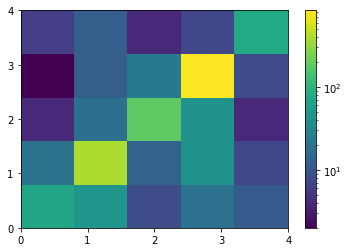

In [34]:
from matplotlib.colors import LogNorm
plt.hist2d(y_pred.argmax(axis = 1), test_y.argmax(axis =1), bins = 5, density=False, norm = LogNorm())
plt.colorbar()
plt.xticks([0,1,2,3,4])
plt.yticks([0,1,2,3,4])

In [38]:
confusion_matrix(y_pred.argmax(axis = 1), test_y.argmax(axis =1))

array([[ 70,  20,   4,   2,   6],
       [ 47, 397,  18,  12,  12],
       [  8,  13, 187,  23,   4],
       [ 19,  44,  45, 841,   7],
       [ 11,   7,   4,   8,  76]])

In [0]:
unique_labels = Binarizer.inverse_transform(np.eye(5))
report = classification_report(test_y.argmax(axis = 1), 
                      y_pred.argmax(axis = 1), 
                      labels = [0,1,2,3,4], 
                      target_names = unique_labels)

In [50]:
print(report)

              precision    recall  f1-score   support

         cbb       0.69      0.45      0.54       155
        cbsd       0.82      0.83      0.82       481
         cgm       0.80      0.72      0.76       258
         cmd       0.88      0.95      0.91       886
     healthy       0.72      0.72      0.72       105

    accuracy                           0.83      1885
   macro avg       0.78      0.73      0.75      1885
weighted avg       0.83      0.83      0.83      1885



#Model Performance:

Now we investigate the performance of the model at classifying examples that were not included in the training or in the dev set.

We look at a few metrics: 

> ***Precision*** which is defined as `1 - false positive rate`. One can interpret precision as the purity or cleanness of the sample. 

> ***Recall*** which is defined as `true positive rate`. Recall assigned to each class can be interpreted as the completeness of the sample in that class. 

> ***$F_1$ score*** is the harmonic mean of the precision and recall: $F_1 = 2\times\frac{\mathrm{Precision.Recall}}{\mathrm{Precision + Recall}}$.


By looking at the classification report above, we notice that our model is good at identifying the cmd ,cbsd, cgm, but less promissing at identifying the images in the healthy and the cbb class.

Out of all the leaf images identified as cmd, 88\% are in the true cmd class. Out of all the images in the cmd class 95\% are correctly identified as cmd. 72\% of the objects in the healthy class are true healthy object. Furthermore, out of all the true healthy objects, 72\% are included in the healthy class. 

Note that the cmd class is dominant class in the sample, and the healthy class is the least common example in the data.


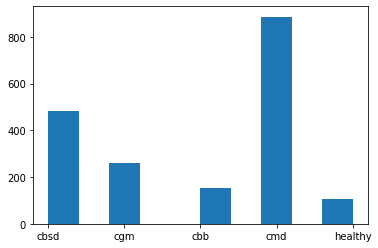

In [52]:
histogram = plt.hist(test_labels)

One way of handling this imbalanced nature of the data is assigning weights to the classes in claculation of the categorical cross entropy loss functions. Introducing such weights will make the model pay more attention to the less common classes in the data.

##How to find a good learning rate

The most impactful hyperparameter of the model is probably the learning rate which we hard-coded in our model. 


One way to find an appropriate value of the learning rate is to make a learning rate scheduler and monitor the behaviour of the validation loss as a function of learning rate:



```
learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch/4)) 
```

This scheduler exponentially grows the learning rate starting at an initial value of $10^{-6}$. This can be passed to the fitting process through the `callbacks` argument



```
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_schedule])
```
Afterwards, one can choose a proper value of this hyperparameter by inspecting the value of the validation loss as a function of learning rate.





